In [3]:
# imports 


import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import copy
from torchvision import transforms
import torch
import csv
import random
import numpy as np
from PIL import Image 
from tqdm import tqdm

import sys
sys.path.append(r'/home/afroehli/coding/util_scripts')
from utils_dataloading.dassl_datum_mod import DatumWithWnid 
from utils_dataloading.imagenet_tree import ImagenetSemanticInfo, ImagenetSemanticSubtree

sys.path.append(r'/home/afroehli/coding/OOD-X-Benchmarks')
from datasets import imagenet_x as i_x, imagenet_r_x as r_x, imagenet_c_x as c_x, imagenet_v2_x as v2_x

# other setup
random.seed(3)

In [5]:
# load datasets
results_available = True 

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_r_sorted.pkl', 'rb') as pickle_file: 
    imagenet_r_sorted = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_x_sorted.pkl', 'rb') as pickle_file: 
    imagenet_x_sorted = pickle.load(pickle_file)

with open('/home/afroehli/coding/pickle_data/dataset_objects/imagenet_x_small_sorted.pkl', 'rb') as pickle_file: 
    imagenet_x_small_sorted = pickle.load(pickle_file)


# load model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vits14.eval()
dinov2_vits14.to(device)

transform = transforms.Compose([transforms.Resize((154, 210)),
                                transforms.ToTensor()])


# load semantic-info object
with open(r'/home/afroehli/coding/pickle_data/imagenet_semantic_info.pkl', 'rb') as pkl_file:
    semantic_info = pickle.load(pkl_file)


# load classes that are common in all imagenet variances 
wnids_common_classes = set()
with open('/home/afroehli/coding/dinov2_ood/storage/union_set_classes.txt', 'r') as union_file: 
    for line in union_file.readlines():
        common_wnid = line.rstrip('\n')
        wnids_common_classes.add(common_wnid)

print(f'Common classes found: {len(wnids_common_classes)}')
for n, common_class_wnid in enumerate(wnids_common_classes): 
    print(f'{n + 1}: {semantic_info.wnid_to_classname[common_class_wnid]}') 

# only in case model output was stored before
# load already calculated embeddings
if results_available:
    with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'rb') as pickle_file:
        imagenet_x_val_results = pickle.load(pickle_file)
    print(f'Number of precomputed classes of Imagenet-X-Val: {len(imagenet_x_val_results)}')
else:
    print('No precomputed classed of Imagenet-X-Val were loaded.')



Device used: cuda


Using cache found in /home/afroehli/.cache/torch/hub/facebookresearch_dinov2_main


Common classes found: 135
1:  chimpanzee
2:  Basset Hound
3:  giant panda
4:  Pomeranian
5:  beaver
6:  Cocker Spaniel
7:  polar bear
8:  bathtub
9:  Afghan Hound
10:  vulture
11:  bee
12:  Rottweiler
13:  orangutan
14:  Indian cobra
15:  sea lion
16:  fly
17:  Whippet
18:  ambulance
19:  Bloodhound
20:  assault rifle
21:  cowboy hat
22:  bow tie
23:  zebra
24:  Scottish Terrier
25:  clownfish
26:  pufferfish
27:  praying mantis
28:  badger
29:  lion
30:  Dalmatian
31:  Boston Terrier
32:  leopard
33:  St. Bernard
34:  Beagle
35:  skunk
36:  cottontail rabbit
37:  gazelle
38:  French Bulldog
39:  chameleon
40:  pug
41:  tabby cat
42:  cannon
43:  eel
44:  Pembroke Welsh Corgi
45:  hyena
46:  toucan
47:  hermit crab
48:  German Shepherd Dog
49:  Golden Retriever
50:  dragonfly
51:  guinea pig
52:  lorikeet
53:  Weimaraner
54:  bison
55:  wheelbarrow
56:  hippopotamus
57:  Siberian Husky
58:  baboon
59:  collie
60:  monarch butterfly
61:  goldfish
62:  pig
63:  great egret
64:  llama
65:

In [ ]:
# compute closest class for each common class 

# for each common-class, find closest class in rest of imagenet-1k (999 candidates)

common_class_comparisons = dict()
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected common-wnids: {len(wnids_common_classes)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for common_wnid in wnids_common_classes:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[common_wnid], axis=0)

    imagenet_wnids.remove(common_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            common_class_comparisons[common_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            common_class_comparisons[common_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    common_class_comparisons[common_wnid].sort(key = lambda ood_id: ood_id[0])
    imagenet_wnids.append(common_wnid)

Number of detected common-wnids: 135
Number of detected imagenet-wnids: 1000


In [7]:
# control output of closest classes 

for n, common_wnid in enumerate(common_class_comparisons.keys()):

    top_three = common_class_comparisons[common_wnid][:3]
    top_three_names = [(semantic_info.wnid_to_classname[tt_wnid], tt_score) for tt_score, tt_wnid in top_three]
    print(f'{n}: CC-Class = {semantic_info.wnid_to_classname[common_wnid]}, Next classes = {top_three_names}')

0: CC-Class =  chimpanzee, Next classes = [(' gorilla', np.float32(235.94043)), (' siamang', np.float32(286.9928)), (' orangutan', np.float32(309.70462))]
1: CC-Class =  Basset Hound, Next classes = [(' Beagle', np.float32(261.91693)), (' Treeing Walker Coonhound', np.float32(276.79465)), (' English foxhound', np.float32(339.79163))]
2: CC-Class =  giant panda, Next classes = [(' American black bear', np.float32(472.17554)), (' sloth bear', np.float32(484.3158)), (' brown bear', np.float32(489.51086))]
3: CC-Class =  Pomeranian, Next classes = [(' Chow Chow', np.float32(366.84155)), (' Pekingese', np.float32(401.38516)), (' Keeshond', np.float32(410.54218))]
4: CC-Class =  beaver, Next classes = [(' otter', np.float32(317.88696)), (' marmot', np.float32(359.8711)), (' mink', np.float32(389.43878))]
5: CC-Class =  Cocker Spaniel, Next classes = [(' Irish Setter', np.float32(292.4155)), (' Sussex Spaniel', np.float32(298.002)), (' Clumber Spaniel', np.float32(362.87933))]
6: CC-Class =  

In [10]:
# store class split 

with open('/home/afroehli/coding/dinov2_ood/storage/class_split.csv', 'w', newline='') as class_split_table:
    split_writer = csv.writer(class_split_table, delimiter=';')

    for common_wnid in common_class_comparisons.keys():
        closest_class_wnid = common_class_comparisons[common_wnid][0][1]
        split_writer.writerow([common_wnid, closest_class_wnid])


In [3]:
# util functions  

def get_random_class() -> str:
    all_classes = list(imagenet_x_sorted.keys())
    n_classes = len(all_classes)
    next_int = random.randint(0, n_classes - 1)
    next_class = all_classes[next_int]

    return next_class

In [4]:
# variables for later use

ood_id_random_combination = []
random_compare_set = dict()

In [ ]:
# calculate embedding for new classes 

# random_set_size = 10 

all_imagenet_classes = list(imagenet_x_sorted.keys())
new_class_processed = 0

for wnid in tqdm(all_imagenet_classes):
# for it, ood_id_pair in enumerate(class_splits): 

#     ood_wnid, id_wnid = ood_id_pair 
#     random_class_wnid = get_random_class()
#     random_set = [get_random_class() for i in range(0, random_set_size)]

#     ood_id_random_combination.append((ood_wnid, id_wnid, random_class_wnid))
#     random_compare_set[(ood_wnid, id_wnid, random_class_wnid)] = copy.deepcopy(random_set)

#     print(f'Iteration {it}. Next triple processed: {semantic_info.wnid_to_classname[ood_wnid]}',
#           f', {semantic_info.wnid_to_classname[id_wnid]}, {semantic_info.wnid_to_classname[random_class_wnid]}.\n'
#           f'Random-compare-set: {[semantic_info.wnid_to_classname[random_wnid] for random_wnid in random_set]}.')
    
    
#     image_processed = 0
    
#     wnid_set = [ood_wnid, id_wnid, random_class_wnid]
#     wnid_set.extend(random_set)
#     for wnid in wnid_set:

        covered_classes = list(imagenet_x_val_results.keys())
        
        if not wnid in covered_classes:
            for dassl_instance in imagenet_x_sorted[wnid]:

                pic_data = transform(Image.open(dassl_instance.impath).convert('RGB')).unsqueeze(0)
                pic_data_cuda = pic_data.to(device)

                model_out = dinov2_vits14(pic_data_cuda)
                try: 
                    imagenet_x_val_results[wnid].append(model_out.cpu().data.numpy()[0])
                except KeyError:
                    imagenet_x_val_results[wnid] = [model_out.cpu().data.numpy()[0]]

        else:
            print(f'Class *{semantic_info.wnid_to_classname[wnid]}* is already covered.')
            
        new_class_processed += 1

print(f'New classes were processed: {new_class_processed}')

In [46]:
# store calculated classes

with open('/home/afroehli/coding/pickle_data/imagenet_x_val_results.pkl', 'wb') as pickle_file:
    pickle.dump(imagenet_x_val_results, pickle_file, pickle.HIGHEST_PROTOCOL)

In [21]:
statistics_dict = dict()

# calculate statistics 

for class_combination in ood_id_random_combination: 

    ood_wnid, id_wnid, random_wnid = class_combination 

    ood_results = np.array(imagenet_x_val_results[ood_wnid])
    id_results = np.array(imagenet_x_val_results[id_wnid])
    random_results = np.array(imagenet_x_val_results[random_wnid])
    # shape = 10 x 50 x 384  (N pictures)
    random_compare_results = np.array([imagenet_x_val_results[comp_wnid] for comp_wnid in random_compare_set[class_combination]])

    ood_mean = np.mean(ood_results, axis=0)
    id_mean = np.mean(id_results, axis=0)
    random_mean = np.mean(random_results, axis=0)

    # shape = 10 x 384
    random_compare_mean_1 = np.mean(random_compare_results, axis=1)
    # shape = 384
    random_compare_mean = np.mean(random_compare_mean_1, axis=0)
    
    ood_std = np.std(ood_results, axis=0)
    id_std = np.std(id_results, axis=0)
    random_std = np.std(random_results, axis=0)
    
    diff_id_ood = np.abs(id_mean - ood_mean)
    diff_random_ood = np.abs(random_mean - ood_mean)
    diff_random_comp_ood = np.abs(random_compare_mean - ood_mean)

    statistics_dict[class_combination] = dict()
    
    true_false_list = (diff_id_ood < diff_random_ood).tolist()
    id_is_nearer = true_false_list.count(True)
    statistics_dict[class_combination]['id_random'] = id_is_nearer

    true_false_list = (diff_id_ood < ood_std).tolist()
    id_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['id_std'] = id_within_std

    true_false_list = (diff_random_ood < ood_std).tolist()
    random_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['random_std'] = random_within_std

    true_false_list = (diff_id_ood < diff_random_comp_ood).tolist()
    id_is_nearer_comp = true_false_list.count(True)
    statistics_dict[class_combination]['id_random_comp'] = id_is_nearer_comp 

    true_false_list = (diff_random_comp_ood < ood_std).tolist()
    random_comp_within_std = true_false_list.count(True)
    statistics_dict[class_combination]['random_comp_std'] = random_comp_within_std

    statistics_dict[class_combination]['id_sum'] = np.sum(diff_id_ood)
    statistics_dict[class_combination]['random_sum'] = np.sum(diff_random_ood)
    statistics_dict[class_combination]['random_comp_sum'] = np.sum(diff_random_comp_ood)



In [28]:
# prepare statistics 

all_combinations = list(statistics_dict.keys())
comb_mapping = dict()
for n, comb in enumerate(all_combinations):
    comb_mapping[n] = comb 

all_combinations_numbers = list(comb_mapping.keys())

id_nearer_rand = [(statistics_dict[combination]['id_random'] / 384) * 100 for combination in all_combinations]

id_nearer_rand_df = pd.DataFrame(data=list(zip(all_combinations_numbers, id_nearer_rand)), columns=['Comb', 'Val'])
id_nearer_rand_df['Rel'] = 'ID-Ran'

id_nearer_rand_comp = [(statistics_dict[combination]['id_random_comp'] / 384) * 100 for combination in all_combinations]
id_nearer_rand_comp_df = pd.DataFrame(data=list(zip(all_combinations_numbers, id_nearer_rand_comp)), columns=['Comb', 'Val'])
id_nearer_rand_comp_df['Rel'] = 'ID-RanComp'

fifty_percent = [50 for i in range(0, len(all_combinations))]
fifty_percent_df = pd.DataFrame(data=list(zip(all_combinations_numbers, fifty_percent)), columns=['Comb', 'Val'])
fifty_percent_df['Rel'] = '50%'

id_sum_diff_ood = [statistics_dict[combination]['id_sum'] for combination in all_combinations]
id_sum_diff_mean = [sum(id_sum_diff_ood) / len(id_sum_diff_ood) for i in range(0, 40)]
id_sum_diff_lower_half = sorted(id_sum_diff_ood)[:20]
id_sum_lower_half_mean = [sum(id_sum_diff_lower_half) / 20 for i in range(0, 40)]

random_sum_diff_ood = [statistics_dict[combination]['random_sum'] for combination in all_combinations]
random_sum_diff_mean = [sum(random_sum_diff_ood) / len(random_sum_diff_ood) for i in range(0, 40)]

random_comp_sum_diff_ood = [statistics_dict[combination]['random_comp_sum'] for combination in all_combinations]
random_comp_sum_diff_mean = [sum(random_comp_sum_diff_ood) / len(random_comp_sum_diff_ood) for i in range(0, 40)]
ran_comp_diff_lower_half = sorted(random_comp_sum_diff_ood)[:20]
ran_comp_lower_half_mean = [sum(ran_comp_diff_lower_half) / 20 for i in range(0, 40)]

# pd dataframes

diff_mean_df = pd.concat([id_nearer_rand_df, id_nearer_rand_comp_df, fifty_percent_df], ignore_index=True)
diff_sum_df = pd.DataFrame(data=list(zip(id_sum_diff_ood, random_sum_diff_ood, random_comp_sum_diff_ood, 
                                         id_sum_diff_mean, random_sum_diff_mean, random_comp_sum_diff_mean,
                                         id_sum_lower_half_mean, ran_comp_lower_half_mean)), 
                           columns=['ID-Sum', 'Ran-Sum', 'RanComp-Sum', 'ID-SumMean', 'Ran-SumMean', 'RanComp-SumMean',
                                    'ID-LH', 'RanComp-LH'])

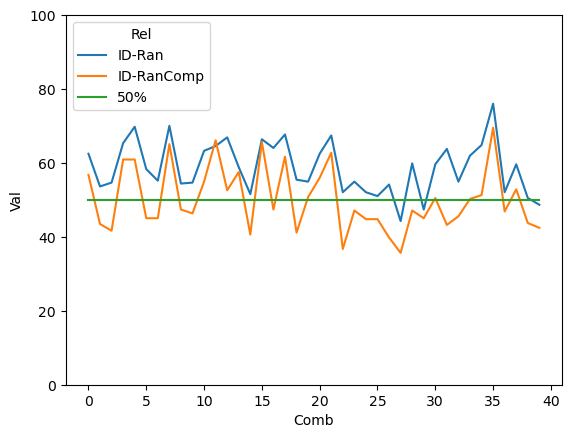

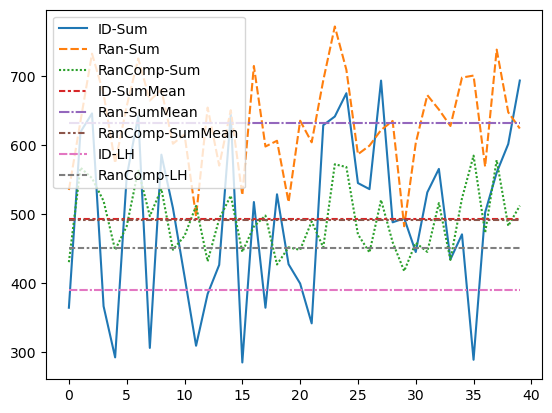

In [29]:
 # visualize statistics 

plt.ylim((0, 100))
sns.lineplot(data=diff_mean_df, x='Comb', y='Val', hue='Rel')
plt.show()

sns.lineplot(data=diff_sum_df)
plt.show()

In [41]:
# identify 50% of worst id-ood matches regarding mean distance 
# 

sum_combination_dict = dict()

for combination in all_combinations:
    sum_combination_dict[float(statistics_dict[combination]['id_sum'])] = combination 

sorted_dict = sorted(sum_combination_dict)
print(sorted_dict)

worst_id_ood_matches = []
for p, diff_sum in enumerate(sorted_dict):

    ood_wnid, id_wnid, ran_wnid = sum_combination_dict[diff_sum]
    id_name = semantic_info.wnid_to_classname[id_wnid]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]

    print(f'{p}: Scored {diff_sum:.2e}: OOD = {ood_name}, ID = {id_name}')

print(f'Combinations printed: {len(sorted_dict)} from possible {len(all_combinations)} combinations.')

[285.52801513671875, 289.4336853027344, 292.9093017578125, 306.568359375, 309.7046203613281, 342.04351806640625, 364.65673828125, 364.68670654296875, 366.841552734375, 384.62213134765625, 399.7071838378906, 410.1962890625, 426.5854797363281, 427.532958984375, 434.56048583984375, 445.22161865234375, 470.74700927734375, 488.12548828125, 493.9937744140625, 502.389892578125, 508.62213134765625, 517.4906005859375, 528.6527099609375, 531.45068359375, 536.09912109375, 544.8900146484375, 554.5610961914062, 560.0919189453125, 565.3636474609375, 585.909912109375, 601.3419189453125, 618.6402587890625, 628.5443115234375, 641.086669921875, 641.65869140625, 643.666015625, 645.576904296875, 674.760986328125, 693.0130615234375, 693.08740234375]
0: Scored 2.86e+02: OOD =  Standard Poodle, ID =  Toy Poodle
1: Scored 2.89e+02: OOD =  cheetah, ID =  leopard
2: Scored 2.93e+02: OOD =  Whippet, ID =  Italian Greyhound
3: Scored 3.07e+02: OOD =  gorilla, ID =  orangutan
4: Scored 3.10e+02: OOD =  chimpanzee,

In [ ]:
# for each ood-class, find closest class in rest of imagenet-1k (999 candidates)

ood_class_comparisons = dict()
all_ood_wnids = [id_ood[0] for id_ood in class_splits]
imagenet_wnids = list(imagenet_x_val_results.keys())

print(f'Number of detected ood-wnids: {len(all_ood_wnids)}')
print(f'Number of detected imagenet-wnids: {len(imagenet_wnids)}')

for ood_wnid in all_ood_wnids:

    # calculate mean of model-output for this class 
    ood_mean = np.mean(imagenet_x_val_results[ood_wnid], axis=0)

    imagenet_wnids.remove(ood_wnid)
    for class_wnid in imagenet_wnids: 

        # calculate mean of selected class
        class_mean = np.mean(imagenet_x_val_results[class_wnid], axis=0)
        diff_ood = np.abs(ood_mean - class_mean)
        sum_class_diff = np.sum(diff_ood)
        try:
            ood_class_comparisons[ood_wnid].append((sum_class_diff, class_wnid))
        except KeyError:
            ood_class_comparisons[ood_wnid] = [(sum_class_diff, class_wnid)]

    # sort calculated mean differences
    ood_class_comparisons[ood_wnid].sort(key = lambda ood_id: ood_id[0])
    
    imagenet_wnids.append(ood_wnid)

Number of detected ood-wnids: 40
Number of detected imagenet-wnids: 1000
Total compare classes for n01616318: 999
Total compare classes for n02106550: 999
Total compare classes for n02096585: 999
Total compare classes for n02112137: 999
Total compare classes for n02091134: 999
Total compare classes for n02086240: 999
Total compare classes for n02056570: 999
Total compare classes for n02480855: 999
Total compare classes for n01534433: 999
Total compare classes for n02749479: 999
Total compare classes for n02108915: 999
Total compare classes for n02481823: 999
Total compare classes for n01694178: 999
Total compare classes for n02236044: 999
Total compare classes for n02423022: 999
Total compare classes for n02113799: 999
Total compare classes for n02814860: 999
Total compare classes for n01632777: 999
Total compare classes for n01986214: 999
Total compare classes for n02097298: 999
Total compare classes for n02098286: 999
Total compare classes for n02066245: 999
Total compare classes for

In [50]:
# print closest compare classes for each ood-class

for ood_wnid in all_ood_wnids: 

    top_five = ood_class_comparisons[ood_wnid][:5]
    top_five_names = [(semantic_info.wnid_to_classname[wnid], score) for score, wnid in top_five]
    ood_name = semantic_info.wnid_to_classname[ood_wnid]
    print(f'OOD = {ood_name}: {top_five_names}')


OOD =  vulture: [(' bald eagle', np.float32(364.6867)), (' kite (bird of prey)', np.float32(374.1024)), (' hornbill', np.float32(427.8051)), (' ptarmigan', np.float32(438.59735)), (' black stork', np.float32(446.6934))]
OOD =  Rottweiler: [(' Black and Tan Coonhound', np.float32(247.84436)), (' Dobermann', np.float32(274.29382)), (' Miniature Pinscher', np.float32(354.40723)), (' Greater Swiss Mountain Dog', np.float32(369.6695)), (' Entlebucher Sennenhund', np.float32(377.0548))]
OOD =  Boston Terrier: [(' French Bulldog', np.float32(313.06226)), (' Staffordshire Bull Terrier', np.float32(401.3598)), (' Boxer', np.float32(438.5884)), (' American Staffordshire Terrier', np.float32(439.02612)), (' toy terrier', np.float32(443.41534))]
OOD =  Chow Chow: [(' Pomeranian', np.float32(366.84155)), (' Keeshond', np.float32(374.4064)), (' Samoyed', np.float32(429.12982)), (' Pekingese', np.float32(445.51138)), (' Great Pyrenees dog', np.float32(469.20425))]
OOD =  Whippet: [(' Ibizan Hound', n